First, importing all the tools needed for this project 

In [1]:
import numpy as np
import pandas as pd 
from scipy import linalg 
import datetime 
import math 
from sqlalchemy import create_engine
import matplotlib.pylab as plt
%matplotlib inline
from sklearn import datasets
import seaborn as sns

%config InlineBackend.figure_format = 'svg'
%matplotlib inline 

In [2]:
engine = create_engine("sqlite:////turnstiles.db")

This function gets all the MTA data directly from the website:

In [3]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs,ignore_index= True)
        
week_nums = [210925,210918,210911,210904, 210828, 210821,210814,210807,210731,210724,210717,210710,210703,210626,210619,210612,210605,210529,
            210522,210515,210508,210501,210424,210417]
turnstiles_df = get_data(week_nums)

Removing space in columns 

In [4]:
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]

get DATE_TIME in one column

In [5]:
turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

Sorting values and dropping dublicates

In [6]:
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [7]:
turnstiles_daily = (turnstiles_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE","TIME","DATE_TIME","EXITS"],as_index=False)
                        .ENTRIES.first())

In [8]:
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES","PREV_EXITS"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES","EXITS"]
                                                       .apply(lambda grp: grp.shift(1)))

<ipython-input-8-8ee9df317339>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_daily[["PREV_DATE", "PREV_ENTRIES","PREV_EXITS"]] = (turnstiles_daily


In [9]:
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

function retunrns daily entries and daily exits

In [10]:
def get_daily_counts(row,t,pt, max_counter):
    counter = row[t] - row[pt]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        print(row[t], row[pt])
        return 0
    return counter

In [11]:
turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts,t="ENTRIES",pt="PREV_ENTRIES", axis=1, max_counter=40000)

6 154694.0
3082 1390173.0
29 479907.0
14 67653.0
18 4341004.0
375 18398491.0
262161 337910.0
14 1028362.0
16 765804.0
393216 1.0
5 150038.0
18182709 5120087.0
5120226 18182709.0
9728986 1159624.0
1159708 9728986.0
692904 5769943.0
5770052 692904.0
10 247996.0
327680 756269765.0
39 328024.0
262152 553649999.0
4 262152.0
262152 4.0
25 262152.0
193 8049630.0
0 5309746.0
262145 568.0
10 468616.0
458752 24.0
589827 953.0
16 2651127.0
393219 459438.0
458754 262214.0
2 458758.0
167790067 702272.0
151 5610355.0
27 59592.0
149 132517.0
35 9769328.0
33565227 188201.0
31 8724126.0
458766 2578.0
2147432317 8421832.0
6 106396.0
20 649205.0
458753 262144.0
393216 458752.0
2 72848.0
54 659349.0
100 92161.0
164 150473.0
393216 728.0
327680 4.0
1 327690.0
9 2627869.0
66 3272795.0
327680 262144.0
15 89658.0
67 59609.0
64 124319.0
272 392076.0
8 4735529.0
67 1605140.0
5671 4298891.0
0 117440512.0
250918 6349746.0
6349790 250918.0
2597061 3500726.0
3500758 2597061.0
8986986 29107.0
29159 8986986.0
47891 5

In [12]:
turnstiles_daily["DAILY_EXITS"] = turnstiles_daily.apply(get_daily_counts,t="EXITS",pt="PREV_EXITS", axis=1, max_counter=40000)

4 167444.0
517 995824.0
62 154058.0
6 808418.0
154 7504853.0
7 67960.0
4688676 4640239.0
15 538441.0
14 1653840.0
17166513 2567144.0
2567236 17166513.0
11343332 868404.0
868460 11343332.0
994878 10733000.0
10733162 994878.0
17 100324.0
38 436767843.0
0 469762048.0
63 2357391.0
0 3196184.0
124 689992.0
11 2192493.0
268473354 1083236.0
187 2246287.0
1 1076720.0
100678103 413088.0
36 8512839.0
34 94763.0
671146375 2645729.0
7 1025567.0
1 440948.0
39 160229.0
0 67865.0
50 205674.0
12 274285.0
6 2944261.0
146 2544401.0
23 161084.0
65 43656.0
16 56331.0
162 205767.0
5 1090165.0
100 86053.0
164 152516.0
42 561847.0
3844 494213.0
761186 17941692.0
17942019 761186.0
2634738 7790914.0
7791164 2634738.0
11186662 73546.0
73814 11186662.0
21012 5099959.0
5100127 21012.0
10489132 49188.0
49282 10489132.0
0 594353.0
594439 0.0
306 1152627.0
14 751600.0
1003 271146.0
14484466 852978.0
852978 14484466.0
800988285 4318079.0
4318092 800988285.0
15894763 166123.0
166125 15894763.0
2133796536 55614.0
55627

Getting total traffic by adding daily entries and daily exits

In [13]:
turnstiles_daily['total_traffic'] = turnstiles_daily['DAILY_ENTRIES'] + turnstiles_daily['DAILY_EXITS']

fuction returns sorted time 

In [14]:
def get_time(row): 
    if row['TIME'] >= '00:00:00' and row['TIME'] <'02:00:00':
        time = '00:00:00'
    elif row['TIME'] >= '02:00:00' and row['TIME'] <='04:00:00':
        time = '04:00:00'
    elif row['TIME'] > '04:00:00' and row['TIME'] <='08:00:00':
        time = '08:00:00'
    elif row['TIME'] > '08:00:00' and row['TIME'] <='12:00:00':
        time = '12:00:00'
    elif row['TIME'] > '10:00:00' and row['TIME'] <='16:00:00':
        time = '16:00:00'
    elif row['TIME'] > '16:00:00' and row['TIME'] <='20:00:00':
        time = '20:00:00'
    elif row['TIME'] > '20:00:00' and row['TIME'] <='23:59:59':
        time = '00:00:00'
    return time

In [15]:
turnstiles_daily["NEW_TIME"] = turnstiles_daily.apply(get_time, axis=1)

Fuction that gets day number

In [16]:
turnstiles_daily['day_of_week'] = turnstiles_daily.DATE_TIME.dt.dayofweek

In [17]:
def get_day(row): 
    if row['day_of_week'] in [0,1,2,3,4]:
        day = 'weekday'
    else:
        day = 'weekend'

    return day

Getting top 5 busiest stations

In [18]:
station_daily = turnstiles_daily.groupby(["STATION"])[['DAILY_ENTRIES', 'DAILY_EXITS','total_traffic']].sum().sort_values(['DAILY_ENTRIES','DAILY_EXITS'], ascending=[False,False])
top = station_daily.head().reset_index()

In [ ]:
top

drawing top 5 busiest stations

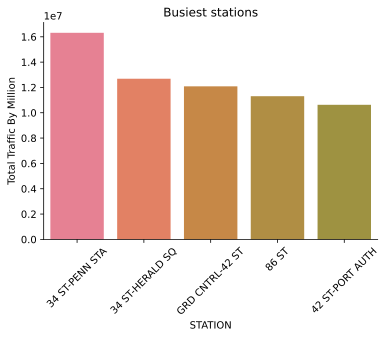

In [19]:
plt.title('Busiest stations')
sns.barplot(x = 'STATION',y='total_traffic',data=top,palette = sns.color_palette("husl", 20));
plt.ylabel('Total Traffic By Million')
plt.xticks(rotation =45)
sns.despine()
plt.savefig('FootTraffic.JPG')

A function that takes a dataframe, list of stations, and weektype either weekday or weekend

In [20]:
def get_graph(df,stations,WeekEnd_WeekDay):
    for station in stations:
        ST = df[(df["STATION"] == station)]
        ST=ST[['DATE_TIME','TIME','DAILY_ENTRIES','DAILY_EXITS','NEW_TIME',"total_traffic"]].reset_index()
        get = ST.groupby(['DATE_TIME','NEW_TIME'])[['DAILY_ENTRIES', 'DAILY_EXITS','total_traffic']].sum().reset_index()
        get['day_of_week'] = get.DATE_TIME.dt.dayofweek
        get['day'] = get.apply(get_day, axis=1)
        APR_MAY= get[get['DATE_TIME'].between('2021-04-01 00:00:00', '2021-05-31 22:00:00', inclusive=False)]
        JUN_JULY= get[get['DATE_TIME'].between('2021-06-01 00:00:00', '2021-07-31 22:00:00', inclusive=False)]
        AUG_SEP= get[get['DATE_TIME'].between('2021-08-01 00:00:00', '2021-09-30 22:00:00', inclusive=False)]
        AM =APR_MAY.groupby(['day','DATE_TIME','NEW_TIME'])[['total_traffic']].mean().reset_index()
        JJ =JUN_JULY.groupby(['day','DATE_TIME','NEW_TIME'])[['total_traffic']].mean().reset_index()
        AS =AUG_SEP.groupby(['day','DATE_TIME','NEW_TIME'])[['total_traffic']].mean().reset_index()
        AM_weekday = AM[(AM["day"] == WeekEnd_WeekDay)]
        JJ_weekday = JJ[(JJ["day"] == WeekEnd_WeekDay)]
        AS_weekday = AS[(AS["day"] == WeekEnd_WeekDay)]
        draw_AM = AM_weekday.groupby(['NEW_TIME'])[['total_traffic']].mean().reset_index()
        draw_JJ = JJ_weekday.groupby(['NEW_TIME'])[['total_traffic']].mean().reset_index()
        draw_AS = AS_weekday.groupby(['NEW_TIME'])[['total_traffic']].mean().reset_index()
        plt.title(f'Avrage traffic for 6 Months for {station}')
        plt.plot(draw_AM['NEW_TIME'], draw_AM['total_traffic'], label = "APR-MAY")
        plt.plot( draw_JJ['NEW_TIME'],draw_JJ['total_traffic'], label = "JUN-JUL")
        plt.plot( draw_AS['NEW_TIME'],draw_AS['total_traffic'], label = "AUG-SUP")
        plt.xlabel('Time')
        plt.ylabel('Number of foot traffic')
        plt.grid()
        plt.legend()
        plt.show()
        plt.savefig(f'FootTraffic_{station}.PNG')

In [21]:
st = ['34 ST-PENN STA','34 ST-HERALD SQ','GRD CNTRL-42 ST', '86 ST', '42 ST-PORT AUTH']

# Average traffic in Weekday

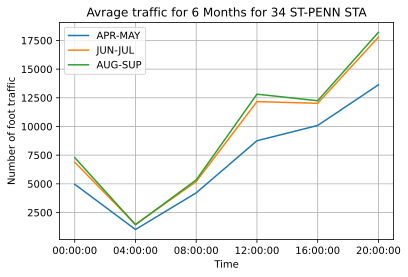

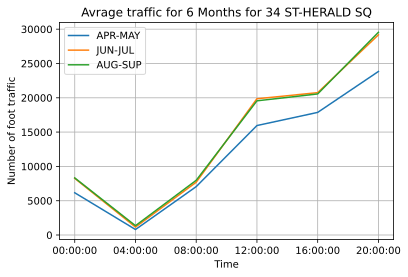

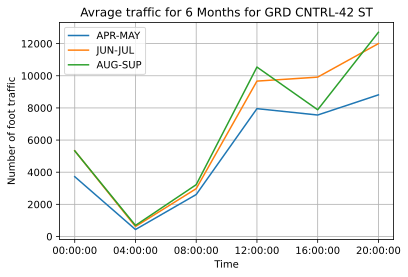

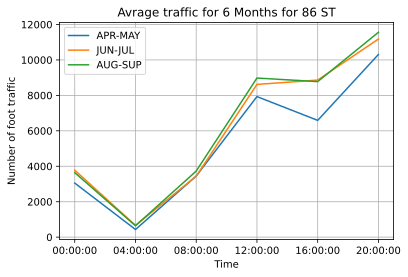

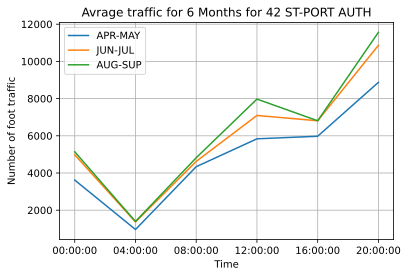

<Figure size 432x288 with 0 Axes>

In [22]:
get_graph(turnstiles_daily,st,'weekday')

# Average traffic in Weekend 

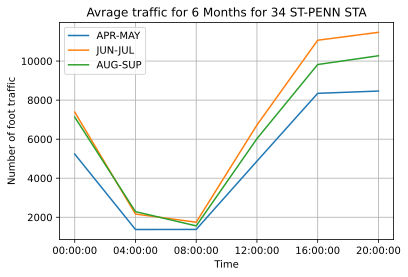

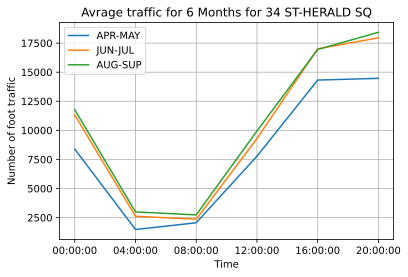

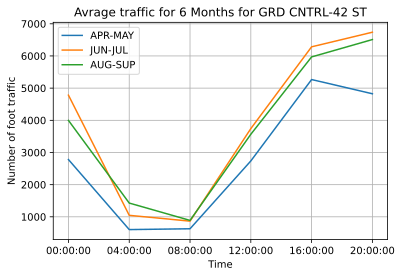

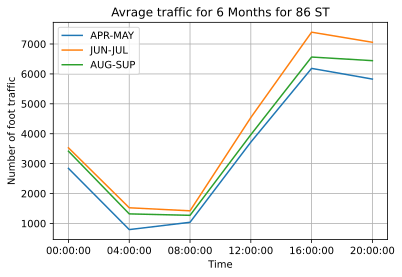

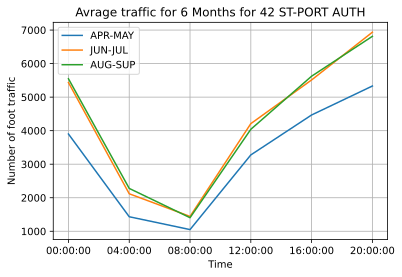

<Figure size 432x288 with 0 Axes>

In [23]:
get_graph(turnstiles_daily,st,'weekend')

In [ ]:
pd.read_sql('SELECT * FROM STATION;', engine)